In [ ]:
# | hide
import datasets

datasets.logging.set_verbosity(datasets.logging.ERROR)

import torch

torch.multiprocessing.set_start_method("spawn")  # good solution !!!!
torch.cuda.is_available()

True

# Paper - Code Analysis Results

> Paper results for the performance of code models on different code constructs!

- skip_exec: true

In [ ]:
# | hide
!pip install -U git+https://github.com/ncoop57/code_tokenizers.git
!download_grammars

## Dataset Preparation

In order to construct our dataset, we used the GPL 3.0 version of the [codeparrot/github-code]() dataset as the models we are evaluating explicitly remove GPL licensed code, so there is a less chance of data leakage. Additionally, we filter out code that goes beyond 4096 characters long as the AST parser we use can be slow for very long code snippets. We also filter out code that is not written in Python, as we are only evaluating Python code models.

In [ ]:
from datasets import load_dataset

ds = load_dataset(
    "bigcode/the-stack-smol",
    split="train",
    data_dir="data/python",
    cache_dir="/work/.cache/huggingface/datasets",
)

filtered_ds = ds.filter(lambda example: len(example["content"]) < 4096)
len(filtered_ds)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /work/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/10 [00:00<?, ?ba/s]

6080

Next we filter out repositories that do not have multiple files in the dataset as we are primarly concerned with internal vs. external method call prediction performance. We then extract all the method definitions and invocations and filter out any examples that do not have internal method invocations. Will also filter out internal methods that are very common such as get and set. Lastly, we ensure there is an even representation of internal and external method calls in the dataset.

In [ ]:
def find_duplicates(items):
    # Create an empty set to store the items that we have already seen
    seen = set()

    # Create an empty list to store the duplicates that we find
    duplicates = []

    # Loop through each item in the list
    for item in items:
        # If the item is already in the "seen" set, then it must be a duplicate
        if item in seen:
            # Add the duplicate to the list
            duplicates.append(item)
        # If the item is not in the "seen" set, then add it to the set
        else:
            seen.add(item)

    # Return the list of duplicates
    return duplicates


repo_names = find_duplicates(filtered_ds["repository_name"])

repo_files = {}
for repo_name in repo_names:
    rows_w_repo = filtered_ds.filter(
        lambda example: example["repository_name"] == repo_name
    )

    if len(rows_w_repo) > 1:
        repo_files[repo_name] = [row["content"] for row in rows_w_repo]
        if len(repo_files) > 400:
            break

# filter out repos with only one file
filtered_ds = filtered_ds.filter(
    lambda example: example["repository_name"] in repo_files
)
len(filtered_ds)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

374

In [ ]:
# |eval: false
from code_tokenizers.core import CodeTokenizer
from transformers import AutoModelForCausalLM

model_name = "bigcode/santacoder"
py_tokenizer = CodeTokenizer.from_pretrained(
    model_name, "python", padding_token="<|endoftext|>"
)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
py_tokenizer.tokenizer

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


PreTrainedTokenizerFast(name_or_path='bigcode/santacoder', vocab_size=49152, model_max_len=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'pad_token': '<|endoftext|>'})

In [ ]:
# |eval: false
from code_tokenizers.helpers import get_internal_methods


def example_internal_methods(example):
    internal_methods = get_internal_methods([example["content"]], py_tokenizer)
    repo_internal_methods = get_internal_methods(
        repo_files[example["repository_name"]], py_tokenizer
    )
    repo_internal_methods = repo_internal_methods - internal_methods
    return repo_internal_methods


# add the internal methods to the dataset
filtered_ds = filtered_ds.map(
    lambda example: {"internal_methods": example_internal_methods(example)}
)
# filter out repos with no internal methods
filtered_ds = filtered_ds.filter(lambda example: len(example["internal_methods"]) > 0)
len(filtered_ds)

  0%|          | 0/293 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

293

In [ ]:
# |eval: false
from functools import partial
from transformers import default_data_collator


def code_collator(batch):
    merged_ast = []
    for b in batch:
        merged_ast.append(b.pop("merged_ast"))

    batch = default_data_collator(batch)
    batch["merged_ast"] = merged_ast
    return batch


def tokenizer_wrapper(tokenizer, example, column, *args, **kwargs):
    return tokenizer(
        example[column], internal_methods=example["internal_methods"], *args, **kwargs
    )


# Setup tokenizer
tokenizer = partial(tokenizer_wrapper, py_tokenizer, column="content")
tokenizer.decode = py_tokenizer.decode

In [ ]:
# |eval: false
from perplexed.core import perplexed

cross_dist, token_cnt = perplexed(
    model.cuda(),
    filtered_ds,
    tokenizer=tokenizer,
    column="content",
    semantic_column="merged_ast",
    batch_size=4,
    num_proc=32,
    device="cuda",
    collate_fn=code_collator,
    pass_row=True,
    return_tokens=True,
    return_distributions=True,
    compute_perplexity=False,
)

Tokenizing dataset #26:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #6:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #30:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #16:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #31:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #21:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #29:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #19:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #22:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #8:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #5:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #14:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #15:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #4:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #17:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #28:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #20:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #11:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #9:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #13:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #0:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #10:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #24:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #12:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #2:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #3:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #25:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #18:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #7:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #1:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #23:   0%|          | 0/3 [00:00<?, ?ba/s]

Tokenizing dataset #27:   0%|          | 0/3 [00:00<?, ?ba/s]

Output()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")


def visualize_perplexities(perplexities, tokens, title, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.boxplot(data=perplexities, palette="Set2")
    ax.set_xticklabels(tokens)
    ax.set_title(title)
    plt.xticks(rotation=45, ha="right")
    plt.show()

In [ ]:
most_common = token_cnt.most_common()
method_invocations = [
    t
    for t in most_common
    if t[0].startswith("<argument_list") or t[0].startswith("<call")
]
internals = [t for t in method_invocations if "internal" in t[0]]
externals = [t for t in method_invocations if "internal" not in t[0]]

In [ ]:
# sort by name
internals = sorted(internals, key=lambda x: x[0])
externals = sorted(externals, key=lambda x: x[0])

In [ ]:
internal_crosses = [cross_dist[token] for token, _ in internals]
external_crosses = [cross_dist[token] for token, _ in externals]

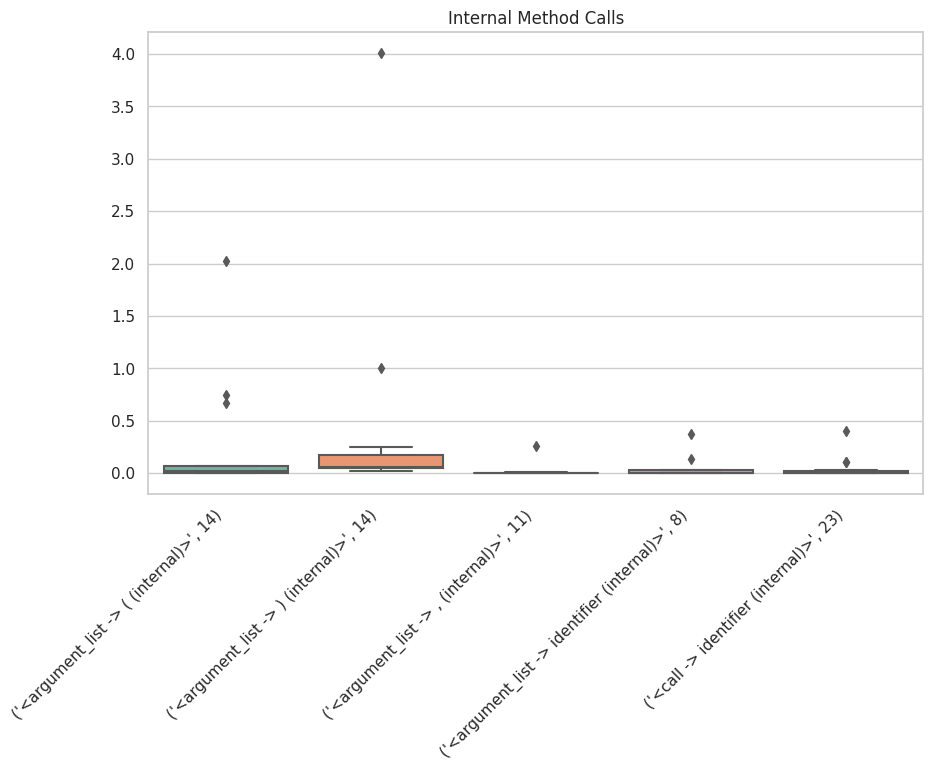

In [ ]:
visualize_perplexities(
    internal_crosses, internals, "Internal Method Calls", "internal_method_calls.png"
)

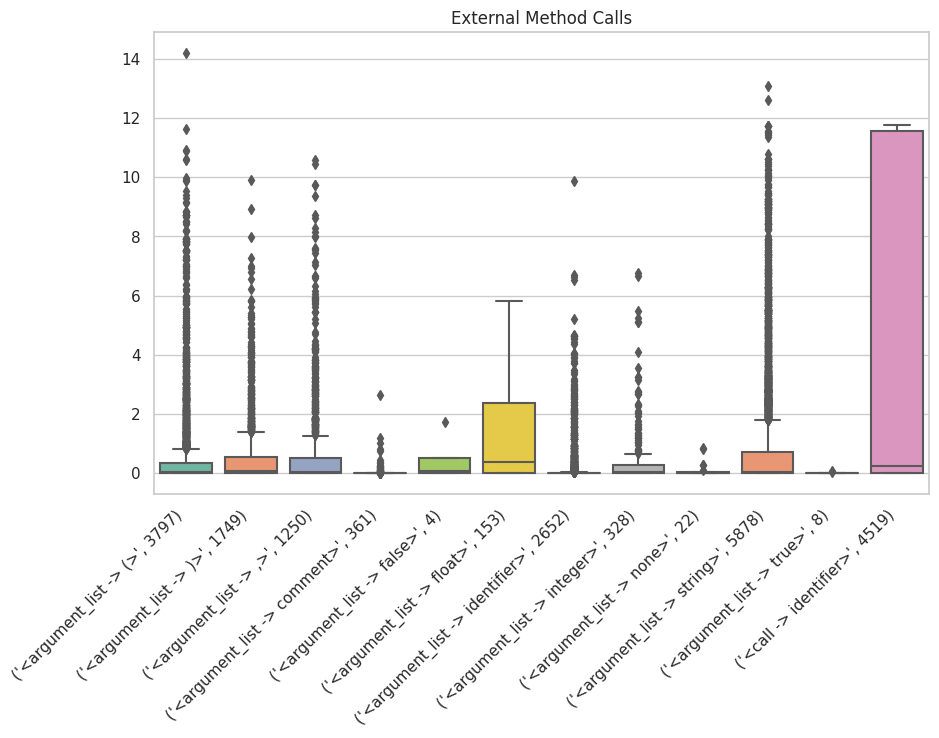

In [ ]:
visualize_perplexities(
    external_crosses, externals, "External Method Calls", "external_method_calls.png"
)

In [ ]:
ast_tokens = [
    t
    for t in most_common
    if (t[0].startswith("<") or t[0].endswith(">")) and "->" in t[0]
][:10]
bpe_tokens = [
    t
    for t in most_common
    if (not t[0].startswith("<") and not t[0].endswith(">")) and "->" not in t[0]
][:10]

In [ ]:
ast_tokens, bpe_tokens

([('<module -> comment>', 256136),
  ('<import_from_statement -> from>', 84241),
  ('<import_statement -> import>', 54511),
  ('<expression_statement -> string>', 48463),
  ('<class_definition -> class>', 13860),
  ('<attribute -> identifier>', 11733),
  ('<assignment -> identifier>', 11627),
  ('<future_import_statement -> from>', 8235),
  ('<argument_list -> string>', 5878),
  ('<call -> identifier>', 4519)],
 [('.', 6405),
  ('_', 6387),
  ('\n', 3728),
  ('(', 3227),
  (',', 3227),
  ('\n   ', 2382),
  ('\n       ', 2358),
  (' =', 2073),
  ('0', 1942),
  ('1', 1914)])

In [ ]:
ast_crosses = [cross_dist[token] for token, _ in ast_tokens]
bpe_crosses = [cross_dist[token] for token, _ in bpe_tokens]

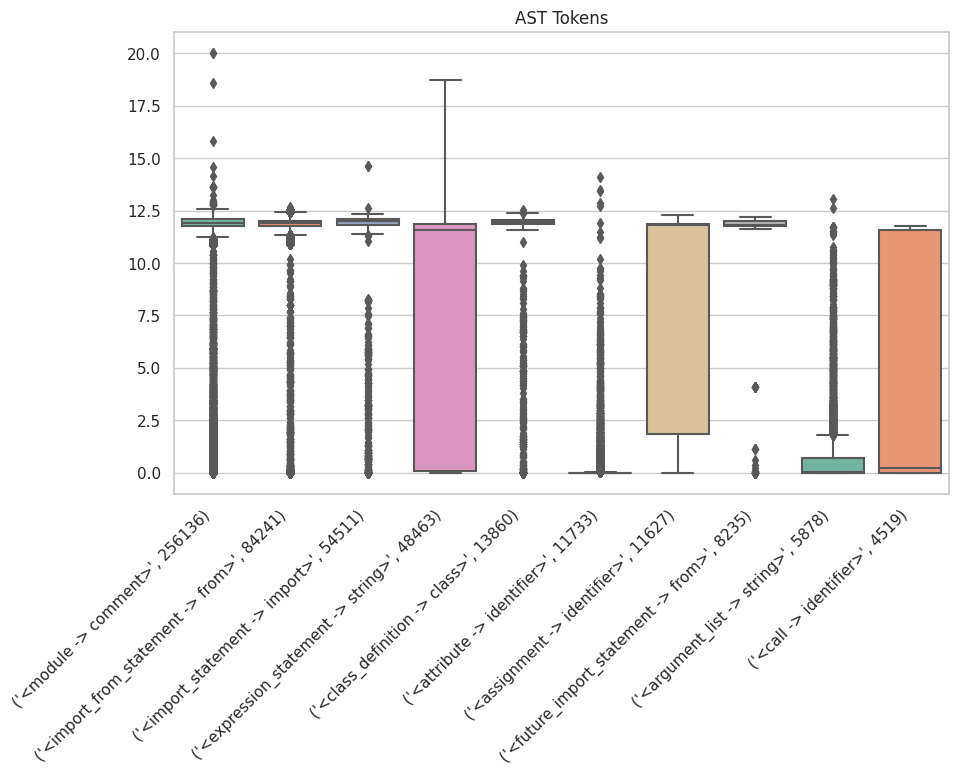

In [ ]:
visualize_perplexities(ast_crosses, ast_tokens, "AST Tokens", "ast_tokens.png")

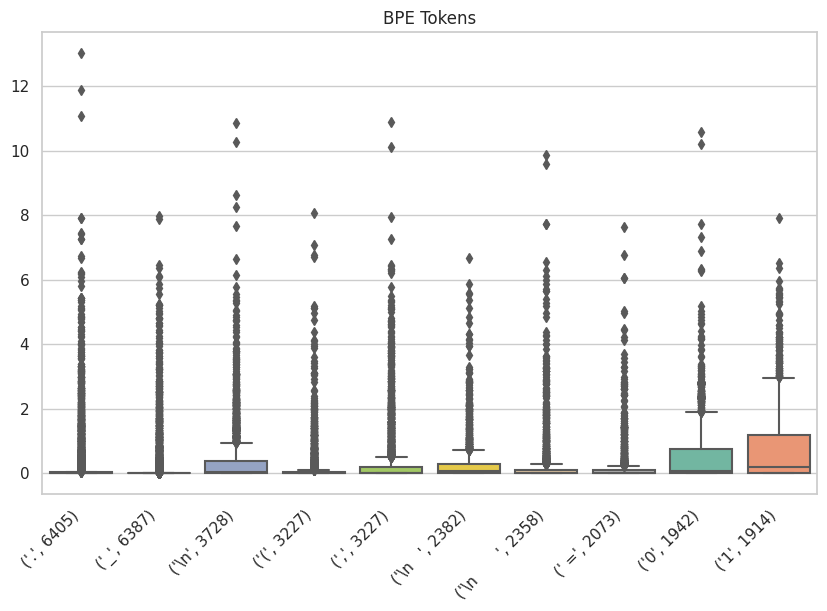

In [ ]:
visualize_perplexities(bpe_crosses, bpe_tokens, "BPE Tokens", "bpe_tokens.png")

In [ ]:
#|eval: false
from code_tokenizers.core import CodeTokenizer
from transformers import AutoModelForCausalLM

model_name = "bigcode/santacoder"
py_tokenizer = CodeTokenizer.from_pretrained(model_name, "python", padding_token="<|endoftext|>")
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
py_tokenizer.tokenizer

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


PreTrainedTokenizerFast(name_or_path='bigcode/santacoder', vocab_size=49152, model_max_len=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|endoftext|>', '<fim-prefix>', '<fim-middle>', '<fim-suffix>', '<fim-pad>']})

In [ ]:
ast_tokens_least = [
    t
    for t in most_common
    if (t[0].startswith("<") or t[0].endswith(">")) and "->" in t[0]
][::-1][:10]
bpe_tokens_least = [
    t
    for t in most_common
    if (not t[0].startswith("<") and not t[0].endswith(">")) and "->" not in t[0]
][::-1][:10]

In [ ]:
ast_crosses_least = [cross_dist[token] for token, _ in ast_tokens_least]
bpe_crosses_least = [cross_dist[token] for token, _ in bpe_tokens_least]

In [ ]:
worst_perform = mean_crosses.most_common(10)
worst_perform

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


[('Sticker', 19.77587127685547),
 (' Framework', 18.601856231689453),
 ('proved', 15.978879928588867),
 ('ril', 15.792886734008789),
 ('BM', 15.57440185546875),
 ('PyTorch', 15.425578117370605),
 ('hore', 15.266545295715332),
 ('transforms', 15.242853164672852),
 (" '{{", 14.778332710266113),
 (' {?', 14.725968360900879)]

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()